In [1]:
'LC08_L1GT_172070_20181125_20181210_01_T2_B9.TIF'

'LC08_L1GT_172070_20181125_20181210_01_T2_B9.TIF'

In [ ]:
import os
import sys
import csv
import rasterio
import ogr, gdal
import numpy as np
import pandas as pd
import earthpy as et
import cartopy as cp
import geopandas as gpd
from rasterio import plot
from matplotlib import colors
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely.geometry import mapping


from glob import glob 
from rasterio.plot import plotting_extent
import earthpy.spatial as es
import earthpy.plot as ep
#----------------------------modules for cloud masking --------------------------
import numpy.ma as ma
import earthpy.mask as em
#------------------------ Modules for changing the crs of a shape file ----------
from osgeo import ogr, osr
import os

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin = None, midpoint = None, vmax = None, clip = False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip = None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0.0, 0.5, 1.0]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

'''============================== Entering the Name of the field to be Analysed ======================================'''  
#crop_extent = 'Chartonel/Chartonel'
crop_extent = 'Gaulunia/GauluniaP1'

#==================================== Files containing the data(images) to be analysed ================================ 
#rootdir = '/media/emmanuel/Transcend/Gaulunia2018'
rootdir = '/media/emmanuel/Transcend/SOYBEAN PROJECT/DATA COLLECTION/Gaulunia'

min = -1.0
mid = 0.0
max = 1.0


for subdir1, dirs1, files1 in os.walk(crop_extent):
    for file1 in files1:
        if file1.endswith('.shp') and  file1[-6:] != '1u.shp':
            cropping_path = os.path.join(subdir1, file1)
            #Changcrs(cropping_path, in_epsg, out_epsg)
            croperfile = file1[:-4]
            croper1 = crop_extent + '/' + file1[:-4]
            crop_field = gpd.read_file(os.path.join(subdir1, file1))
            #if not os.path.exists(crop_extent):
                #os.mkdir(crop_extent)

print(crop_field.crs)

try:
    os.remove(crop_extent + '/' + croperfile + '.txt')
except:
    pass


#============================ Changing CRS of shapefile from epsg:32735 to epsg:32735==================================
in_epsg = 32735
out_epsg = 32635
in_shp = cropping_path
out_shp = cropping_path[:-4] + '1u.shp'

driver = ogr.GetDriverByName('ESRI Shapefile')

# input SpatialReference
inSpatialRef = osr.SpatialReference()
inSpatialRef.ImportFromEPSG(in_epsg)

# output SpatialReference
outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(out_epsg)

# create the CoordinateTransformation
coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

# get the input layer
inDataSet = driver.Open(in_shp)
inLayer = inDataSet.GetLayer()

# create the output layer
if os.path.exists(out_shp):
    driver.DeleteDataSource(out_shp)
outDataSet = driver.CreateDataSource(out_shp)
outLayer = outDataSet.CreateLayer("reproject", geom_type=ogr.wkbMultiPolygon)

# add fields
inLayerDefn = inLayer.GetLayerDefn()
for i in range(0, inLayerDefn.GetFieldCount()):
    fieldDefn = inLayerDefn.GetFieldDefn(i)
    outLayer.CreateField(fieldDefn)

# get the output layer's feature definition
outLayerDefn = outLayer.GetLayerDefn()

# loop through the input features
inFeature = inLayer.GetNextFeature()
while inFeature:
    # get the input geometry
    geom = inFeature.GetGeometryRef()
    # reproject the geometry
    geom.Transform(coordTrans)
    # create a new feature
    outFeature = ogr.Feature(outLayerDefn)
    # set the geometry and attribute
    outFeature.SetGeometry(geom)
    for i in range(0, outLayerDefn.GetFieldCount()):
        outFeature.SetField(outLayerDefn.GetFieldDefn(i).GetNameRef(), inFeature.GetField(i))
    # add the feature to the shapefile
    outLayer.CreateFeature(outFeature)
    # dereference the features and get the next input feature
    outFeature = None
    inFeature = inLayer.GetNextFeature()

# Save and close the shapefiles
inDataSet = None
outDataSet = None
#====================================================================================================================


for subdir1, dirs1, files1 in os.walk(crop_extent):
    for file1 in files1:
        if file1.endswith('1u.shp'):
            cropping_path = os.path.join(subdir1, file1)
            crop_field2 = gpd.read_file(os.path.join(subdir1, file1))
            #if not os.path.exists(crop_extent):
                #os.mkdir(crop_extent)
print(crop_field2.crs)
#===================================================================================================================
#                               SENTINEL-2
#===================================================================================================================


# cd, ce  and cv are used to make sure that the code finds the red and nir bands of the same image       
# cd, ce  and cv are used to make sure that the code finds the red and nir bands of the same image       
cv = 1
cd = 9
ce = 21
for subdir, dirs, files in os.walk(rootdir):
    try:
        for file in files:
            if file[23:26] == 'B03':
                date = file[13:15] + '-' + file[11:13]+ '-' + file[7:11]
                cv = 8
                with rasterio.open(os.path.join(subdir, file)) as src:
                    extent_geojson = mapping(crop_field['geometry'][0])
                    ndvi_crop, crop_affine = mask(src, shapes = [extent_geojson], crop = True)
                    soap_lidar_meta = src.meta.copy()

                soap_lidar_meta.update({'driver':'GTiff', 'height':ndvi_crop.shape[1], 'width':ndvi_crop.shape[2], 'transform':crop_affine})
                cr_ext = rasterio.transform.array_bounds(soap_lidar_meta['height'], soap_lidar_meta['width'], soap_lidar_meta['transform'])
                bound_order = [0]
                cr_extent = [cr_ext[b] for b in bound_order]
                cr_extent, crop_field.total_bounds
                greencrop = ndvi_crop[0]
                
            if file[23:26] == 'B04':
                date = file[13:15] + '-' + file[11:13]+ '-' + file[7:11]
                ce = 8
                with rasterio.open(os.path.join(subdir, file)) as src:
                    extent_geojson = mapping(crop_field['geometry'][0])
                    ndvi_crop, crop_affine = mask(src, shapes = [extent_geojson], crop = True)
                    soap_lidar_meta = src.meta.copy()

                soap_lidar_meta.update({'driver':'GTiff', 'height':ndvi_crop.shape[1], 'width':ndvi_crop.shape[2], 'transform':crop_affine})
                cr_ext = rasterio.transform.array_bounds(soap_lidar_meta['height'], soap_lidar_meta['width'], soap_lidar_meta['transform'])
                bound_order = [0]
                cr_extent = [cr_ext[b] for b in bound_order]
                cr_extent, crop_field.total_bounds
                redcrop = ndvi_crop[0]
               
            


            if file[23:26] == 'B08':
                date1 = file[13:15] + '-' + file[11:13]+ '-' + file[7:11]
                cd = 8
                with rasterio.open(os.path.join(subdir, file)) as src:
                    extent_geojson = mapping(crop_field['geometry'][0])
                    ndvi_crop, crop_affine = mask(src, shapes = [extent_geojson], crop = True)
                    soap_lidar_meta = src.meta.copy()

                soap_lidar_meta.update({'driver':'GTiff', 'height':ndvi_crop.shape[1], 'width':ndvi_crop.shape[2], 'transform':crop_affine})
                cr_ext = rasterio.transform.array_bounds(soap_lidar_meta['height'], soap_lidar_meta['width'], soap_lidar_meta['transform'])
                bound_order = [0]
                cr_extent = [cr_ext[b] for b in bound_order]
                cr_extent, crop_field.total_bounds
                nircrop1 = ndvi_crop[0]
                               
                
        if cv == cd and cd == ce:
            if int(date[3:5]) == 11:
                maskred = 1800
                masknir = 1750
                maskgreen = 2150
            elif int(date[3:5]) == 12:
                maskred = 2900
                masknir = 1800
                maskgreen = 1700
            elif int(date[3:5]) == 1:
                maskred = 2000
                masknir = 3200
                maskgreen = 850
            elif int(date[3:5]) == 2:
                maskred = 2000
                masknir = 3000
                maskgreen = 1150
            elif int(date[3:5]) == 3:
                maskred = 2000
                masknir = 1500
                maskgreen = 1200
            elif int(date[3:5]) == 4:
                maskred = 2000
                masknir = 1190
                maskgreen = 1600
            elif int(date[3:5]) == 5:
                maskred = 2000
                masknir = 1200
                maskgreen = 2000
                  
            
            masked_red = ma.masked_array(redcrop, mask = (redcrop >= maskred))
            masked_nir = ma.masked_array(nircrop1, mask = (nircrop1 <= masknir))
            masked_green = ma.masked_array(greencrop, mask = (greencrop >= maskgreen))
            
            meangreen = np.nanmean(masked_green)
            meannir = np.nanmean(masked_nir)
            if meannir != 0.0 and meangreen != 0.0:
                
                mx1 = pd.DataFrame(masked_green)
                mx1r = pd.DataFrame(masked_nir)
                mx1 = mx1.replace(np.NaN, 0)
                mx1r = mx1r.replace(np.NaN, 0)
                mx1 = np.array(mx1)
                mx1r = np.array(mx1r)

                mx2 = mx1 == 0
                mx2r = mx1r == 0
                
                #--------------------Applying the masks to the images---------------------
                nircrop2 = em.mask_pixels(nircrop1, mx2)
                nircrop3 = em.mask_pixels(nircrop2, mx2r)
                redcrop = em.mask_pixels(redcrop, mx2)
                redcrop = em.mask_pixels(redcrop, mx2r)
                meanredcrop = np.mean(redcrop)
                meannircrop = np.mean(nircrop3)

                if meanredcrop != np.NaN and meannircrop != np.NaN:
                    
                    masked_green = pd.DataFrame(masked_green)
                    masked_green = masked_green.replace(0, np.NaN)
                    masked_green = np.array(masked_green)
                    
                    nircrop1 = pd.DataFrame(nircrop1)
                    nircrop1 = nircrop1.replace(0, np.NaN)
                    nircrop1 = np.array(nircrop1)
                    
                    greencrop = pd.DataFrame(greencrop)
                    greencrop = greencrop.replace(0, np.NaN)
                    greencrop = np.array(greencrop)

                    fig4 = plt.figure(figsize = (16,16))
                    plt.rc('xtick', labelsize = 20)
                    plt.rc('ytick', labelsize = 20)
                    plt.subplot(221)
                    plt.title('Green band', fontweight = 'bold', fontsize = 30)  
                    plt.imshow(greencrop)
                    plt.grid()
                    plt.subplot(222)
                    plt.title('Near-infrared band', fontweight = 'bold', fontsize = 30)
                    plt.imshow(nircrop1)
                    plt.grid()
                    plt.subplot(223)
                    plt.title('Green: Cloud Mask', fontweight = 'bold', fontsize = 30)
                    plt.imshow(masked_green)
                    plt.grid()
                    plt.subplot(224)
                    plt.title('Near-infrared: Shadow Mask', fontweight = 'bold', fontsize = 30)
                    plt.imshow(masked_nir)
                    plt.grid()
                    plt.savefig(crop_extent +'/' + date + 'MaskS-2.png')
                    plt.close(fig4)

                    np.seterr(divide = 'ignore', invalid = 'ignore')
                    NDVI = (nircrop3 - redcrop)/(nircrop3 + redcrop)

                    NDVI = pd.DataFrame(NDVI)
                    NDVI = NDVI.replace(0, np.NaN)
                    NDVI = np.array(NDVI)
                    Ave_NDVI = np.nanmean(NDVI)
                    print(date, Ave_NDVI, 'S-2')
                    
                    #----------------------------------Plotting NDVI of field---------------------
                    min = -1.0
                    mid = 0.0
                    max = 1.0
                    norm = MidpointNormalize(vmin = min, vmax = max, midpoint = mid)
                    colormap = plt.cm.nipy_spectral
                    fig3 = plt.figure(figsize = (20, 20))
                    plt.rc('xtick', labelsize = 30)
                    plt.rc('ytick', labelsize = 30)
                    plt.title('NDVI Image of Field on\n' + date + '\n', fontsize = 30, fontweight = 'bold')
                    plt.imshow(NDVI, cmap = colormap, vmin = min, vmax = max, norm = norm)
                    plt.colorbar(orientation = 'horizontal', shrink = 0.7)
                    plt.grid()
                    plt.savefig(crop_extent + '/' + date + 'NDVI-S2.png')
                    plt.close(fig3)
                

                    #-------------------------Plotting Histogram of NDVI for Sentinel-2 raster------------------
                    fig4 = plt.figure(figsize = (15, 10))
                    ax = fig4.add_subplot(111)
                    plt.title('NDVI Histogram of Field on\n' + date + '\n', fontsize = 30, fontweight = 'bold')
                    plt.rc('xtick', labelsize = 30)
                    plt.rc('ytick', labelsize = 30)
                    plt.xlabel('NDVI Value', fontsize = 30)
                    plt.ylabel('Number of Pixels', fontsize = 30)
                    x = NDVI[~np.isnan(NDVI)]
                    color = 'blue'
                    ax.hist(x, bins = 30, color = color, histtype = 'bar', ec = 'black')
                    plt.grid()
                    fig4.savefig(crop_extent + '/' + date + 'Histogram' + 'S2.png', dpi = 200, bbox_inches = 'tight', pad_inches = 0.6)
                    plt.close(fig4)
                
                    month = int(date[3:5])
                    date1 = int(date[0:2])

                    if int(month) == 11:
                        date1 = date1 - 19
                    elif int(month) == 12:
                        date1 = 11 + date1
                    elif int(month) == 1:
                        date1 = 42 + date1
                    elif int(month) == 2:
                        date1 = 73 + date1
                    elif int(month) == 3:
                        date1 = 101 + date1
                    elif int(month) == 4:
                        date1 = 132 + date1
                    elif int(month) == 5:
                        date1 = 162 + date1

                    datafile = crop_extent + '/' + croperfile + '.txt'
                    f = open(datafile, 'a+')
                    yes = os.stat(datafile).st_size  == 0
                    if yes is False:
                        f.write(str(date1) + '        ' + str(Ave_NDVI) + '\n')
                    else:
                        f.write('Date           Average_NDVI\n')
                        f.write(str(date1) + '        ' + str(Ave_NDVI) + '\n')
                    f.close()
                cd = 3
                cv = 6
                ce = 23
                
    except:
        pass

#========================================================================================================================
#                                          PLANETSCOPE
#========================================================================================================================

'''
This part of the code operates of Planetscope images:
'''

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file[24:37] == 'AnalyticMS_SR':
            try:
                date = file[6:8] + '-' + file[4:6] + '-' + file[0:4]
                with rasterio.open(os.path.join(subdir, file)) as src:
                    extent_geojson = mapping(crop_field['geometry'][0])
                    ndvi_crop, crop_affine = mask(src, shapes = [extent_geojson], crop = True)
                    soap_lidar_meta = src.meta.copy()

                soap_lidar_meta.update({'driver':'GTiff', 'height':ndvi_crop.shape[1], 'width':ndvi_crop.shape[2], 'transform':crop_affine})
                cr_ext = rasterio.transform.array_bounds(soap_lidar_meta['height'], soap_lidar_meta['width'], soap_lidar_meta['transform'])
                bound_order = [0, 2, 1, 3]
                cr_extent = [cr_ext[b] for b in bound_order]
                cr_extent, crop_field.total_bounds
                redcrop = ndvi_crop[2]
                nircrop = ndvi_crop[3] 
                greencrop = ndvi_crop[1]
                meanred = np.nanmean(redcrop)
                meannir = np.nanmean(nircrop)
                

                if int(date[3:5]) == 11 :
                    maskred = 2700
                    masknir = 1650
                    maskgreen = 2220
                    #print(date, maskred, np.max(redcrop))
                elif int(date[3:5]) == 12:
                    maskred = 2700
                    masknir = 2000
                    maskgreen = 1800
                    #print(date, maskred, np.max(redcrop))
                elif int(date[3:5]) == 1 :
                    maskred = 2100
                    masknir = 2500
                    maskgreen = 1900
                    #print(date, maskred, np.max(redcrop))
                elif int(date[3:5]) == 2:
                    maskred = 1800
                    masknir = 2900
                    maskgreen = 1310
                    #print(date, maskred, np.max(redcrop))
                elif int(date[3:5]) == 3 :
                    maskred = 1200
                    masknir = 2000
                    maskgreen = 1380
                    #print(date, maskred, np.max(redcrop))
                elif int(date[3:5]) == 4:
                    maskred = 2800
                    masknir = 1300
                    maskgreen = 2000
                    #print(date, maskred, np.max(redcrop))
                elif int(date[3:5]) == 5:
                    maskred = 3500
                    masknir = 1300
                    maskgreen = 1700
                    #print(date, maskred, np.max(redcrop))
                    
                masked_red = ma.masked_array(redcrop, mask = (redcrop >= maskred))
                masked_nir = ma.masked_array(nircrop, mask = (nircrop <= masknir))
                masked_green = ma.masked_array(greencrop, mask = (greencrop >= maskgreen))

                if meanred != 0.0 and meannir != 0.0:
                    
                    greencrop = pd.DataFrame(greencrop)
                    greencrop = greencrop.replace(0, np.NaN)
                    greencrop = np.array(greencrop)
                    
                    masked_green = pd.DataFrame(masked_green)
                    masked_green = masked_green.replace(0, np.NaN)
                    masked_green = np.array(masked_green)
                    
                    nircropp = pd.DataFrame(nircrop)
                    nircropp = nircropp.replace(0, np.NaN)
                    nircropp = np.array(nircropp)
        
                    fig4 = plt.figure(figsize = (16,16))
                    plt.rc('xtick', labelsize = 20)
                    plt.rc('ytick', labelsize = 20)
                    fig4.add_subplot(221)
                    plt.title('Green band', fontweight = 'bold', fontsize = 30)
                    plt.imshow(greencrop)
                    plt.grid()
                    fig4.add_subplot(222)
                    plt.title('Near-infrared band', fontweight = 'bold', fontsize = 30)
                    plt.imshow(nircropp)
                    plt.grid()
                    fig4.add_subplot(223)
                    plt.title('Green: Cloud Mask', fontweight = 'bold', fontsize = 30)
                    plt.imshow(masked_green)
                    plt.grid()
                    fig4.add_subplot(224)
                    plt.title('Near-infrared: Shadow Mask', fontweight = 'bold', fontsize = 30)
                    plt.imshow(masked_nir)
                    plt.grid()
                    plt.savefig(crop_extent +'/' + date + 'MaskDove.png')
                    plt.close(fig4)
                    
                    mx1 = pd.DataFrame(masked_green)
                    mx1r = pd.DataFrame(masked_nir)
                    mx1 = mx1.replace(np.NaN, 0)
                    mx1r = mx1r.replace(np.NaN, 0)
                    mx1 = np.array(mx1)
                    mx1r = np.array(mx1r)
                    
                    mx2 = mx1 == 0
                    mx2r = mx1r == 0
                    #--------------------Applying the masks to the images---------------------
                    nircrop = em.mask_pixels(nircrop, mx2)
                    nircrop = em.mask_pixels(nircrop, mx2r)
                    redcrop = em.mask_pixels(redcrop, mx2)
                    redcrop = em.mask_pixels(redcrop, mx2r)
                    meanredcrop = np.nanmean(redcrop)
                    meannircrop = np.nanmean(nircrop)
                    if meannircrop != np.NaN and meanredcrop != np.NaN:


                        np.seterr(divide = 'ignore', invalid = 'ignore')
                        NDVI = (nircrop - redcrop)/(nircrop + redcrop)


                        NDVI = pd.DataFrame(NDVI)
                        NDVI = NDVI.replace(0, np.NaN)
                        NDVI = np.array(NDVI)
                        Ave_NDVI = np.nanmean(NDVI)
                        min = -1.0
                        mid = 0.0
                        max = 1.0
                        norm = MidpointNormalize(vmin = min, vmax = max, midpoint = mid)
                        colormap = plt.cm.nipy_spectral
                        fig3 = plt.figure(figsize = (20,20))
                        plt.rc('xtick', labelsize = 30)
                        plt.rc('ytick', labelsize = 30)
                        plt.title('NDVI Image of Field on\n' + date + '\n', fontsize = 30, fontweight = 'bold')
                        plt.imshow(NDVI, cmap = colormap, vmin = min, vmax = max, norm = norm)
                        plt.colorbar(orientation = 'horizontal', shrink = 0.7)
                        plt.grid()
                        plt.savefig(crop_extent + '/' + date + 'NDVI-Dove.png')
                        plt.close(fig3)

                        #-------------------- Plotting Histogram of NDVI for Sentinel-2 raster---------------------------------------
                        fig6t = plt.figure(figsize = (15, 10))
                        ax = fig6t.add_subplot(111)
                        plt.title('NDVI Histogram of Field on\n' + date + '\n', fontsize = 30, fontweight = 'bold')
                        plt.rc('xtick', labelsize = 30)
                        plt.rc('ytick', labelsize = 30)
                        plt.xlabel('NDVI Value', fontsize = 30)
                        plt.ylabel('Number of Pixels', fontsize = 30)

                        x = NDVI[~np.isnan(NDVI)]
                        color = 'brown'
                        ax.hist(x, bins = 30, color = color, histtype = 'bar', ec = 'black')
                        plt.grid()
                        fig6t.savefig(crop_extent + '/' + date + 'Histogram' + 'Dove.png', dpi = 200, bbox_inches = 'tight', pad_inches = 0.5)
                        plt.close(fig6t)
                        #-------------------------------------------------------------------------------------------------------------
                        print(date, Ave_NDVI, 'D')
                        month = int(file[4:6])
                        date1 = int(file[6:8])
                        if int(month) == 11:
                            date1 = date1 - 19
                        elif int(month) == 12:
                            date1 = 11 + date1
                        elif int(month) == 1:
                            date1 = 42 + date1
                        elif int(month) == 2:
                            date1 = 73 + date1
                        elif int(month) == 3:
                            date1 = 101 + date1
                        elif int(month) == 4:
                            date1 = 132 + date1
                        elif int(month) == 5:
                            date1 = 162 + date1

                        datafile = crop_extent + "/" + croperfile + '.txt'
                        f = open(datafile, 'a+')
                        yes = os.stat(datafile).st_size  == 0
                        if yes is False:
                            f.write(str(date1) + '        ' + str(Ave_NDVI) + '\n')
                        else:
                            f.write('Date           Average_NDVI\n')
                            f.write(str(date1) + '        ' + str(Ave_NDVI) + '\n')
                        f.close()
            except:
                pass

#===================================================================================================================
#                               LANDSAT-8
#===================================================================================================================


# cd, ce  and cv are used to make sure that the code finds the red and nir bands of the same image       
# cd, ce  and cv are used to make sure that the code finds the red and nir bands of the same image       
dv = 1
dd = 9
de = 21
for subdir, dirs, files in os.walk(rootdir):
    try:
        for file in files:
            if file[41:43] == 'B3':
                date = file[23:25] + '-' + file[21:23]+ '-' + file[17:21]
                dv = 8
                with rasterio.open(os.path.join(subdir, file)) as src:
                    extent_geojson = mapping(crop_field2['geometry'][0])
                    ndvi_crop, crop_affine = mask(src, shapes = [extent_geojson], crop = True)
                    soap_lidar_meta = src.meta.copy()

                soap_lidar_meta.update({'driver':'GTiff', 'height':ndvi_crop.shape[1], 'width':ndvi_crop.shape[2], 'transform':crop_affine})
                cr_ext = rasterio.transform.array_bounds(soap_lidar_meta['height'], soap_lidar_meta['width'], soap_lidar_meta['transform'])
                bound_order = [0]
                cr_extent = [cr_ext[b] for b in bound_order]
                cr_extent, crop_field2.total_bounds
                greencrop = ndvi_crop[0]
                
            if file[41:43] == 'B4':
                date = file[23:25] + '-' + file[21:23]+ '-' + file[17:21]
                dd = 8
                with rasterio.open(os.path.join(subdir, file)) as src:
                    extent_geojson = mapping(crop_field2['geometry'][0])
                    ndvi_crop, crop_affine = mask(src, shapes = [extent_geojson], crop = True)
                    soap_lidar_meta = src.meta.copy()

                soap_lidar_meta.update({'driver':'GTiff', 'height':ndvi_crop.shape[1], 'width':ndvi_crop.shape[2], 'transform':crop_affine})
                cr_ext = rasterio.transform.array_bounds(soap_lidar_meta['height'], soap_lidar_meta['width'], soap_lidar_meta['transform'])
                bound_order = [0]
                cr_extent = [cr_ext[b] for b in bound_order]
                cr_extent, crop_field2.total_bounds
                redcrop = ndvi_crop[0]
                
            if file[41:43] == 'B5':
                date = file[23:25] + '-' + file[21:23]+ '-' + file[17:21]
                de = 8
                with rasterio.open(os.path.join(subdir, file)) as src:
                    extent_geojson = mapping(crop_field2['geometry'][0])
                    ndvi_crop, crop_affine = mask(src, shapes = [extent_geojson], crop = True)
                    soap_lidar_meta = src.meta.copy()

                soap_lidar_meta.update({'driver':'GTiff', 'height':ndvi_crop.shape[1], 'width':ndvi_crop.shape[2], 'transform':crop_affine})
                cr_ext = rasterio.transform.array_bounds(soap_lidar_meta['height'], soap_lidar_meta['width'], soap_lidar_meta['transform'])
                bound_order = [0]
                cr_extent = [cr_ext[b] for b in bound_order]
                cr_extent, crop_field2.total_bounds
                nircrop1 = ndvi_crop[0]
                
        if dv == dd and dd == de:
            maskred = 12000
            masknir = 13500
            maskgreen = 10000
            # Masking Clouds and Shadows of the Satellite image using numpys 'ma' module
            masked_red = ma.masked_array(redcrop, mask = (redcrop >= maskred))
            masked_nir = ma.masked_array(nircrop1, mask = (nircrop1 <= masknir))
            masked_green = ma.masked_array(greencrop, mask = (greencrop >= maskgreen))
            
            meangreen = np.nanmean(masked_green)
            meannir = np.nanmean(masked_nir)
            if meannir != 0.0 and meangreen != 0.0:
                
                mx1 = pd.DataFrame(masked_green)
                mx1r = pd.DataFrame(masked_nir)
                mx1 = mx1.replace(np.NaN, 0)
                mx1r = mx1r.replace(np.NaN, 0)
                mx1 = np.array(mx1)
                mx1r = np.array(mx1r)

                mx2 = mx1 == 0
                mx2r = mx1r == 0
                
                #--------------------Applying the masks to the images---------------------
                nircrop2 = em.mask_pixels(nircrop1, mx2)
                nircrop3 = em.mask_pixels(nircrop2, mx2r)
                redcrop = em.mask_pixels(redcrop, mx2)
                redcrop = em.mask_pixels(redcrop, mx2r)
                meanredcrop = np.mean(redcrop)
                meannircrop = np.mean(nircrop3)

                if meanredcrop != np.NaN and meannircrop != np.NaN:
                    
                    masked_green = pd.DataFrame(masked_green)
                    masked_green = masked_green.replace(0, np.NaN)
                    masked_green = np.array(masked_green)
                    
                    nircrop1 = pd.DataFrame(nircrop1)
                    nircrop1 = nircrop1.replace(0, np.NaN)
                    nircrop1 = np.array(nircrop1)
                    
                    greencrop = pd.DataFrame(greencrop)
                    greencrop = greencrop.replace(0, np.NaN)
                    greencrop = np.array(greencrop)

                    fig4 = plt.figure(figsize = (16,16))
                    plt.rc('xtick', labelsize = 20)
                    plt.rc('ytick', labelsize = 20)
                    plt.subplot(221)
                    plt.title('Green band', fontweight = 'bold', fontsize = 30)  
                    plt.imshow(greencrop)
                    plt.grid()
                    plt.subplot(222)
                    plt.title('Near-infrared band', fontweight = 'bold', fontsize = 30)
                    plt.imshow(nircrop1)
                    plt.grid()
                    plt.subplot(223)
                    plt.title('Green: Cloud Mask', fontweight = 'bold', fontsize = 30)
                    plt.imshow(masked_green)
                    plt.grid()
                    plt.subplot(224)
                    plt.title('Near-infrared: Shadow Mask', fontweight = 'bold', fontsize = 30)
                    plt.imshow(masked_nir)
                    plt.grid()
                    plt.savefig(crop_extent +'/' + date + 'Mask-L8.png')
                    plt.close(fig4)

                    np.seterr(divide = 'ignore', invalid = 'ignore')
                    NDVI = (nircrop3 - redcrop)/(nircrop3 + redcrop)

                    NDVI = pd.DataFrame(NDVI)
                    NDVI = NDVI.replace(0, np.NaN)
                    NDVI = np.array(NDVI)
                    Ave_NDVI = np.nanmean(NDVI)
                    print(date, Ave_NDVI,'L8')
                    
                    #----------------------------------Plotting NDVI of field---------------------
                    min = -1.0
                    mid = 0.0
                    max = 1.0
                    norm = MidpointNormalize(vmin = min, vmax = max, midpoint = mid)
                    colormap = plt.cm.nipy_spectral
                    fig3 = plt.figure(figsize = (20, 20))
                    plt.rc('xtick', labelsize = 30)
                    plt.rc('ytick', labelsize = 30)
                    plt.title('NDVI Image of Field on\n' + date + '\n', fontsize = 30, fontweight = 'bold')
                    plt.imshow(NDVI, cmap = colormap, vmin = min, vmax = max, norm = norm)
                    plt.colorbar(orientation = 'horizontal', shrink = 0.7)
                    plt.grid()
                    plt.savefig(crop_extent + '/' + date + 'NDVI-L8.png')
                    plt.close(fig3)
                

                    #-------------------------Plotting Histogram of NDVI for Sentinel-2 raster------------------
                    fig4 = plt.figure(figsize = (15, 10))
                    ax = fig4.add_subplot(111)
                    plt.title('NDVI Histogram of field on\n' + date + '\n', fontsize = 30, fontweight = 'bold')
                    plt.rc('xtick', labelsize = 30)
                    plt.rc('ytick', labelsize = 30)
                    plt.xlabel('NDVI Value', fontsize = 30)
                    plt.ylabel('Number of Pixels', fontsize = 30)
                    x = NDVI[~np.isnan(NDVI)]
                    color = 'magenta'
                    ax.hist(x, bins = 30, color = color, histtype = 'bar', ec = 'black')
                    plt.grid()
                    fig4.savefig(crop_extent + '/' + date + 'Histogram' + 'L8.png', dpi = 200, bbox_inches = 'tight', pad_inches = 0.6)
                    plt.close(fig4)
                
                    month = int(date[3:5])
                    date1 = int(date[0:2])

                    if int(month) == 11:
                        date1 = date1 - 19
                    elif int(month) == 12:
                        date1 = 11 + date1
                    elif int(month) == 1:
                        date1 = 42 + date1
                    elif int(month) == 2:
                        date1 = 73 + date1
                    elif int(month) == 3:
                        date1 = 101 + date1
                    elif int(month) == 4:
                        date1 = 132 + date1
                    elif int(month) == 5:
                        date1 = 162 + date1

                    datafile = crop_extent + '/' + croperfile + '.txt'
                    f = open(datafile, 'a+')
                    yes = os.stat(datafile).st_size  == 0
                    if yes is False:
                        f.write(str(date1) + '        ' + str(Ave_NDVI) + '\n')
                    else:
                        f.write('Date           Average_NDVI\n')
                        f.write(str(date1) + '        ' + str(Ave_NDVI) + '\n')
                    f.close()
            dd = 3
            dv = 6
            de = 23
                             
    except:
        pass
datafile = crop_extent + "/" + croperfile + '.txt'
datafilew = crop_extent + "/" + croperfile + 'w.txt'
datafilew2 = crop_extent + "/" + croperfile + 'w2.txt'

data = pd.read_csv(datafile, delim_whitespace = True, skipinitialspace = True)
data.columns = ['TIME', 'Average_ndvi']
x = data['TIME']
y = data['Average_ndvi']
data = data.sort_values('TIME').drop_duplicates('TIME')
data = data.dropna(how='any')    #to drop if any value in the row has a NaN



tfile2 = open(datafilew, 'w')
tfile2.write(data.to_string(index=False, header = None))
tfile2.close()



try:
    os.remove(datafilew2)
except:
    pass
with open(datafilew, 'r') as f:
    filelines = f.readlines()
    for line in filelines:
        words = line.split()
        #if  int(words[0]) > 60 and int(words[0]) < 75 and float(words[1]) < 0.6:
            #continue
        #if  int(words[0]) > 75 and int(words[0]) < 80 and float(words[1]) < 0.6:
            #continue
        #if  int(words[0]) > 80 and int(words[0]) < 90 and float(words[1]) < 0.6:
            #continue
        #if  int(words[0]) > 60 and int(words[0]) < 100 and float(words[1]) < 0.55:
        #    continue
        #elif int(words[0]) > 80 and int(words[0]) < 117 and float(words[1]) < 0.75:
        #    continue
        if int(words[0]) > 80 and int(words[0]) < 120 and float(words[1]) < 0.7:
            continue
        elif int(words[0]) > 60 and int(words[0]) < 80 and float(words[1]) < 0.55:
            continue
        elif int(words[0]) > 0 and int(words[0]) < 190 and float(words[1]) > 1.0:
            continue
        #elif int(words[0]) > 100 and int(words[0]) < 117 and float(words[1]) < 0.6:
            #continue
        else:
            f = open(datafilew2, 'a+')
            yes = os.stat(datafilew2).st_size  == 0
            if yes is False:
                f.write(words[0] + '        ' + words[1] + '\n')
            else:
                f.write('Day    Average_NDVI\n')
                f.write( words[0]+ '        ' + words[1] + '\n')
            f.close()
            
            
from numpy import *
from scipy.interpolate import *
from scipy import interpolate
from scipy.integrate import trapz, simps
from matplotlib.pyplot import *

data = pd.read_csv(datafilew2, delim_whitespace = True, skipinitialspace = False)
data.columns = ['TIME', 'Average_ndvi']
x = data['TIME']
y = data['Average_ndvi']
data = data.sort_values('TIME').drop_duplicates('TIME')

x = data['TIME']
y = data['Average_ndvi']


list_x = list(x)
#list_x = sorted(list_x)
list_y = list(y)
#list_y = sorted(list_y)
y = np.array(list_y)
x = np.array(list_x)
xp = np.linspace(x.min(), x.max(), 1000)


#-----------------------------------------------------------------------------------------
#             Making a polynomial Best Fit (Machine Learning)
#-----------------------------------------------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

polynomial_features = PolynomialFeatures(degree= 6, include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),("linear_regression", linear_regression)])
pipeline.fit(x[:, np.newaxis], y)

# Evaluating  the model using crossvalidation
scores = cross_val_score(pipeline, x[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10)

y_poly = pipeline.predict(xp[:, np.newaxis])
yp_max = y_poly.max()
xp_max_yp = xp[y_poly.argmax()]
Areap = simps(y_poly, xp)

print('plotting Poly fit')
figt = plt.figure(figsize = (20,20))
plt.rc('xtick', labelsize = 30)
plt.rc('ytick', labelsize = 30)
plt.xlabel("Time (days)", fontsize = 30)
plt.ylabel("Average NDVI", fontsize = 30)
plt.setp(ax, xticks=(), yticks=())
plt.plot(x, y, 'o', label= "Data points")
plt.plot(xp, y_poly,'r-', label="Polynomial best fit", linewidth = 2.5)
plt.title('Average NDVI versus Time: Polynomial best fit\n', fontsize = 30, fontweight = 'bold' )
plt.fill_between(xp, y_poly, color = 'brown', alpha=.5, label = 'Area under graph')
plt.grid()
plt.legend(loc="best", fontsize = 30)
plt.savefig(crop_extent + '/' + croperfile + 'Polynomialfit.png')
plt.close(figt)




#---------------------------------------------------------------------------------------------
#                  Cubic Spline Interpolation fit
#---------------------------------------------------------------------------------------------
s1rev = interpolate.InterpolatedUnivariateSpline (x, y)
# Use a smallish value for s
if len(x) < 33:
    s2 = interpolate.UnivariateSpline (x, y, s = 0.04)
else:
    s2 = interpolate.UnivariateSpline (x, y, s = 0.1)


yc = s2(xp)
Area1c = simps(yc, xp)
yc_max = yc.max()
xc_max = xp[yc.argmax()] 

print('Plotting Cubic Spline Curve')
figr = plt.figure(figsize = (20, 20))
plt.rc('xtick', labelsize = 30)
plt.rc('ytick', labelsize = 30)
plt.xlabel('Time (days)', fontsize = 30)
plt.ylabel('Average NDVI', fontsize = 30)
plt.plot(x, y, 'o', label='Data points')
plt.plot (xp, yc, 'r-', label='Cubic Spline best fit', linewidth = 2.5)
#plt.minorticks_on()
plt.title('Average NDVI vs Time: Cubic Spline Best fit\n',fontsize = 30, fontweight = 'bold')

#plt.rc('xtick', labelsize = 40, fontweight = 'bold')
#plt.rc('ytick', labelsize = 40, fontweight = 'bold')
plt.fill_between(xp, yc, color = 'yellow', alpha=.5, label = 'Area under graph')
plt.grid()
plt.legend(loc = 'best', fontsize = 30)
plt.savefig(crop_extent + '/' + croperfile + 'Cubicspline.png')
plt.close(figr)

#--------------------------------------------------------------------------------------------------
#                      CONVOLUTION  (Moving Average box)
#--------------------------------------------------------------------------------------------------
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

y_smooth = smooth(y, 2)
y_max = y_smooth.max()
x_max = x[y_smooth.argmax()]
Area = simps(y_smooth, x)

print('Plotting Convolve')
figu = plt.figure(figsize = (20, 20))
plt.rc('xtick', labelsize = 30)
plt.rc('ytick', labelsize = 30)
plt.xlabel('Time (days)', fontsize = 30)
plt.ylabel('Average NDVI', fontsize = 30)
plt.title('Average NDVI vs Time: Convolution best fit\n',fontsize = 30, fontweight = 'bold')
plt.plot(x, y, 'o', label='Data points')
#plt.plot (x, y, 'r-', label='Spline, fit', linewidth = 2.5)
plot(x, y_smooth, 'r-', label=' Convolution best fit', linewidth = 2.5)
#plt.minorticks_on()
plt.fill_between(x,y_smooth, color = 'green', alpha=.5, label = 'Area under graph')
plt.grid()
plt.legend(loc = 'best', fontsize = 30)
plt.savefig(crop_extent + '/' + croperfile + 'Convolution.png')
plt.close(figu)


#-----------------------------------------------------------------------------------------------
#   Gaussian Process Modelling
#-----------------------------------------------------------------------------------------------

kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)
X = x.reshape(-1, 1)

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

x_pred = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
y_pred, sigma = gp.predict(x_pred, return_std=True)
x_pred1 = np.reshape(x_pred, x_pred.size)
ygp_max = y_pred.max()
xgp_max = int(x_pred[y_pred.argmax()])
Areagp = simps(y_pred, x_pred1)

print('plotting Gaussian Process')
figv = plt.figure(figsize = (20, 20))
plt.rc('xtick', labelsize = 30)
plt.rc('ytick', labelsize = 30)
plt.xlabel('Time (Days)', fontsize = 30)
plt.ylabel('Average NDVI', fontsize = 30)
plt.title('Average NDVI versus Time: Gaussian Process fit\n', fontsize = 30, fontweight = 'bold')
plt.plot(x, y, 'o', label = 'Data Sample')
plt.plot(x_pred, y_pred, 'g', label = 'Gaussian Process best fit')

plt.fill_between(x_pred1, y_pred, color = 'silver', alpha = 0.5, label = 'Area under graph')
plt.grid()
plt.legend(loc = 'best', fontsize = 30)
plt.savefig(crop_extent + '/' + croperfile + 'GaussianProcess.png')
plt.close(figv)




#------------------------------------------------------------------------------------------------
#           Writting important data to files
#------------------------------------------------------------------------------------------------

datafile2 = 'Polynomial data.txt'
f = open(datafile2, 'a+')
yes = os.stat(datafile2).st_size  == 0
if yes is False:
    f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, yp_max, xp_max_yp, Areap))
else:
    f.write('%5s                %16s               %16s         %17s\n'%('Field', 'Max NDVI', 'Date of Max NDVI', 'Area under curve'))
    f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, yp_max, xp_max_yp, Areap))
f.close()  



datafile3 = 'Cubic Spline data.txt'
f = open(datafile3, 'a+')
yes = os.stat(datafile3).st_size  == 0
if yes is False:
    f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, yc_max, xc_max, Area1c))
else:
    f.write('%5s                %16s               %16s         %17s\n'%('Field', 'Max NDVI', 'Date of Max NDVI', 'Area under curve'))
    f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, yc_max, xc_max, Area1c))
f.close()            


datafile4 = 'Convolution.txt'
f = open(datafile4, 'a+')
yes = os.stat(datafile4).st_size  == 0
if yes is False:
    f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, y_max, x_max, Area))
else:
    f.write('%5s                %16s               %16s         %17s\n'%('Field', 'Max NDVI', 'Date of Max NDVI', 'Area under curve'))
    f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, y_max, x_max, Area))
f.close() 


datafile5 = 'Gaussian Process.txt'
f = open(datafile5, 'a+')
yes = os.stat(datafile5).st_size  == 0
if yes is False:
    f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, ygp_max, xgp_max, Areagp))
else:
    f.write('%5s                %16s               %16s         %17s\n'%('Field', 'Max NDVI', 'Date of Max NDVI', 'Area under curve'))
    f.write('%-20s          %3.6f                  %3.2f                  %3.6f\n'%(croperfile, ygp_max, xgp_max, Areagp))
f.close() 

{'init': 'epsg:32735'}
{}
11-03-2019 0.47592296923803734 S-2
24-02-2019 0.7823914232144973 S-2
26-03-2019 0.4162232271547338 S-2
21-12-2018 0.28841656122876475 S-2
19-02-2019 0.6759802809755366 S-2
05-04-2019 0.2719390057333665 S-2
25-04-2019 0.20755606083932718 S-2
05-05-2019 0.1837319412507259 S-2
21-11-2018 0.14842089457946597 S-2
11-12-2018 0.1978571833910274 S-2
21-03-2019 0.5211041944477728 S-2
31-03-2019 0.3247695200700212 S-2
30-04-2019 0.20864739063271717 S-2
10-05-2019 0.19068507863090844 S-2
10-05-2019 0.19068507863090844 S-2
20-05-2019 0.18089008535406553 S-2
20-05-2019 0.18089008535406553 S-2
20-11-2018 0.17741078399230858 D
21-11-2018 0.22564758232730958 D
22-11-2018 0.2229612501866471 D
22-11-2018 0.22378013270821612 D
02-12-2018 0.236380169411765 D
03-12-2018 0.22724819804303492 D
04-12-2018 0.24282084131055526 D
04-12-2018 0.252929815241883 D
07-12-2018 0.2548768903805962 D
08-12-2018 0.27235139328040764 D
08-12-2018 0.2802941197565738 D
08-12-2018 0.23422052558955272 

/home/emmanuel/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/emmanuel/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/emmanuel/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/emmanuel/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/emmanuel/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:885: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/emmanuel/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy

12-02-2019 0.6556467918893737 D
17-02-2019 0.7733615391425639 D
24-02-2019 0.8337678201429687 D
29-03-2019 0.4565520920524881 D
30-03-2019 0.4204280948595433 D
05-04-2019 0.3479289098096074 D
06-04-2019 0.29659463873021136 D
06-04-2019 0.28177681755340744 D
06-04-2019 0.3138963207873976 D
26-04-2019 0.33973681107844894 D
27-02-2019 0.8167442592678057 D
28-04-2019 0.32797464140034227 D
30-04-2019 0.2730134441567958 D
30-04-2019 0.27508368937547445 D
04-05-2019 0.2632495207918866 D
08-05-2019 0.2796725645943032 D
09-05-2019 0.2917610237187017 D
10-05-2019 0.2865360991898439 D
14-05-2019 0.22100988132355143 D
19-05-2019 0.2977872316365173 D
22-05-2019 0.26087119779429135 D
19-01-2019 0.6965195376325299 D
24-01-2019 0.6861635434895627 D
24-01-2019 0.5433317716139121 D
30-01-2019 0.5410903819697717 D
11-12-2018 0.16103982584479268 L8


Plotting Cubic Spline Curve
0.8320793548957901


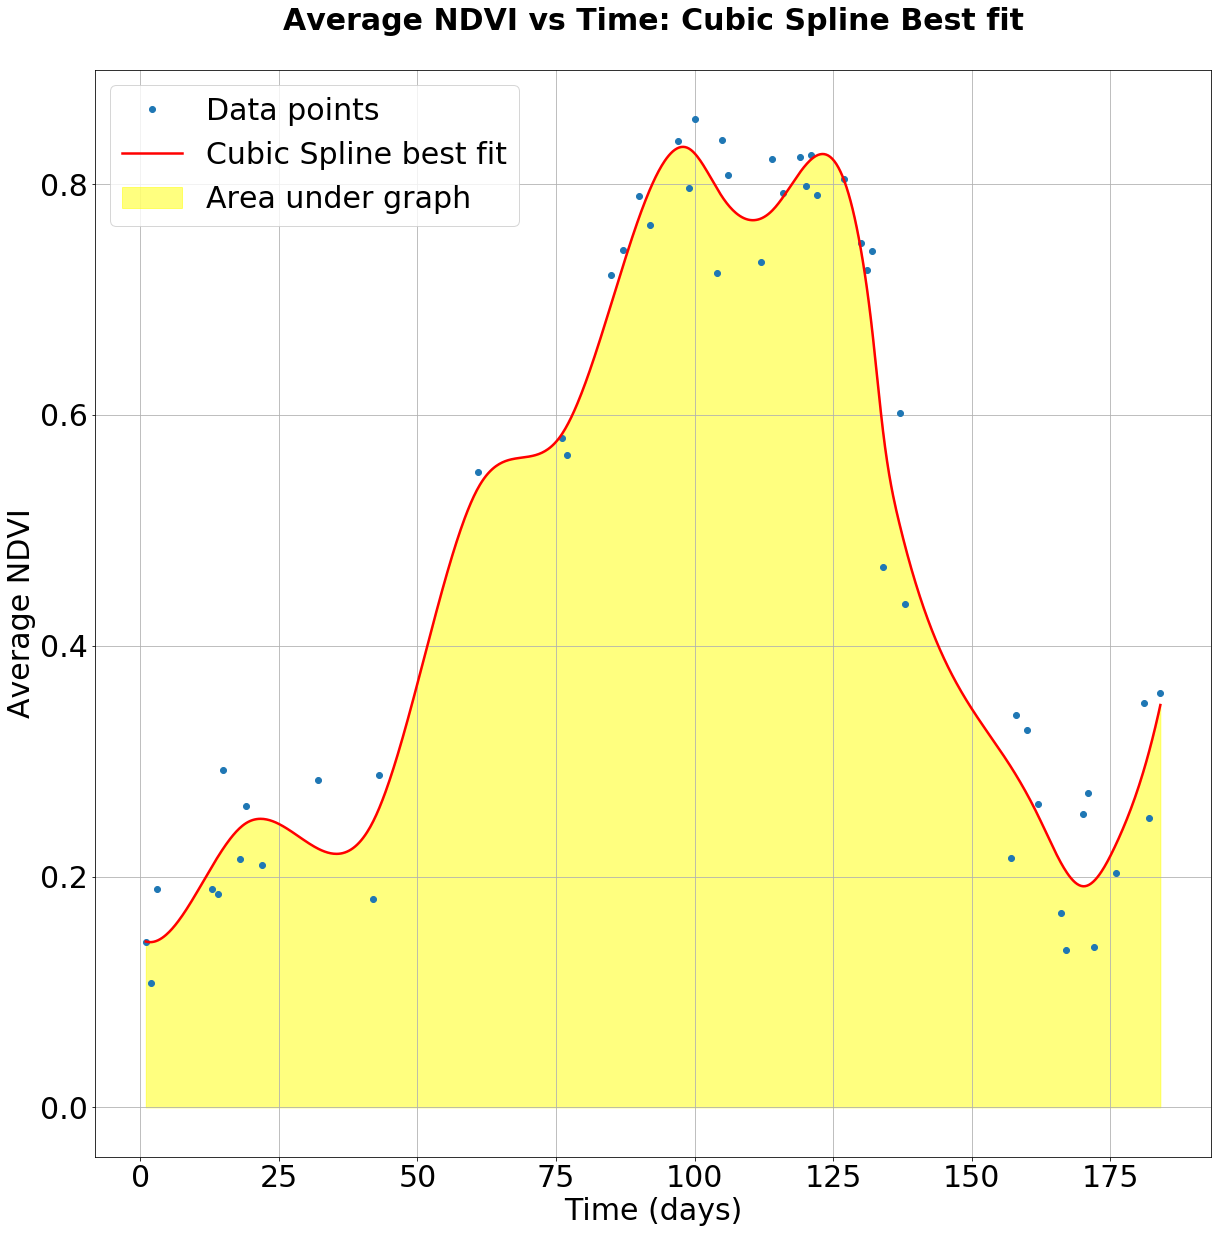

In [25]:

crop_extent = 'Gaulunia/GauluniaCVD'
croperfile = crop_extent[8:]

datafile = crop_extent + "/" + croperfile + '.txt'
datafilew2 = crop_extent + "/" + croperfile + 'w2.txt'

from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import *
from scipy import interpolate
from scipy.integrate import trapz, simps
from matplotlib.pyplot import *

data = pd.read_csv(datafilew2, delim_whitespace = True, skipinitialspace = False)
data.columns = ['TIME', 'Average_ndvi']
x = data['TIME']
y = data['Average_ndvi']
data = data.sort_values('TIME').drop_duplicates('TIME')

x = data['TIME']
y = data['Average_ndvi']


list_x = list(x)
#list_x = sorted(list_x)
list_y = list(y)
#list_y = sorted(list_y)
y = np.array(list_y)
x = np.array(list_x)
xp = np.linspace(x.min(), x.max(), 1000)
#---------------------------------------------------------------------------------------------
#                  Cubic Spline Interpolation fit
#---------------------------------------------------------------------------------------------
s1rev = interpolate.InterpolatedUnivariateSpline (x, y)
# Use a smallish value for s
if len(x) < 33:
    s2 = interpolate.UnivariateSpline (x, y, s = 0.04)
else:
    s2 = interpolate.UnivariateSpline (x, y, s = 0.11)


yc = s2(xp)
Area1c = simps(yc, xp)
yc_max = yc.max()
xc_max = xp[yc.argmax()] 

print('Plotting Cubic Spline Curve')
figr = plt.figure(figsize = (20, 20))
plt.rc('xtick', labelsize = 30)
plt.rc('ytick', labelsize = 30)
plt.xlabel('Time (days)', fontsize = 30)
plt.ylabel('Average NDVI', fontsize = 30)
plt.plot(x, y, 'o', label='Data points')
plt.plot (xp, yc, 'r-', label='Cubic Spline best fit', linewidth = 2.5)
#plt.minorticks_on()
plt.title('Average NDVI vs Time: Cubic Spline Best fit\n',fontsize = 30, fontweight = 'bold')

#plt.rc('xtick', labelsize = 40, fontweight = 'bold')
#plt.rc('ytick', labelsize = 40, fontweight = 'bold')
plt.fill_between(xp, yc, color = 'yellow', alpha=.5, label = 'Area under graph')
plt.grid()
plt.legend(loc = 'best', fontsize = 30)
plt.savefig('CubicSpline.png')


print(yc_max)

plotting Gaussian Process
0.8178613461911795


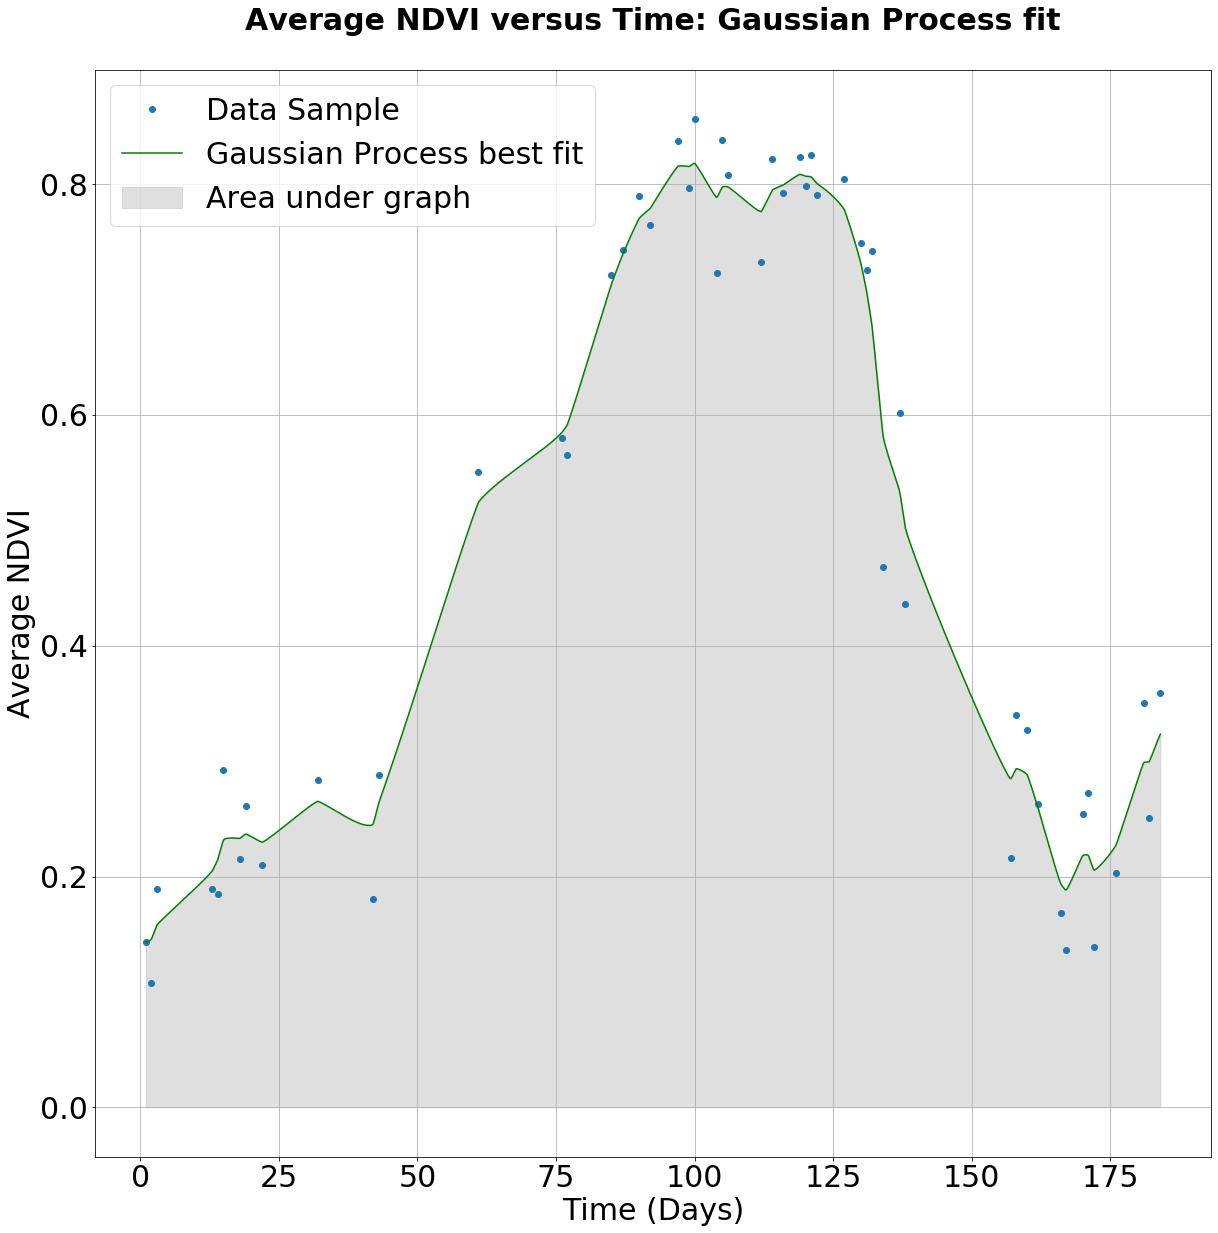

In [24]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
#-----------------------------------------------------------------------------------------------
#   Gaussian Process Modelling
#-----------------------------------------------------------------------------------------------

kernel = ConstantKernel() + Matern(length_scale=0.5, nu=0.6) + WhiteKernel(noise_level=0.2)
X = x.reshape(-1, 1)

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

x_pred = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
y_pred, sigma = gp.predict(x_pred, return_std=True)
x_pred1 = np.reshape(x_pred, x_pred.size)
ygp_max = y_pred.max()
xgp_max = int(x_pred[y_pred.argmax()])
Areagp = simps(y_pred, x_pred1)

print('plotting Gaussian Process')
figv = plt.figure(figsize = (20, 20))
plt.rc('xtick', labelsize = 30)
plt.rc('ytick', labelsize = 30)
plt.xlabel('Time (Days)', fontsize = 30)
plt.ylabel('Average NDVI', fontsize = 30)
plt.title('Average NDVI versus Time: Gaussian Process fit\n', fontsize = 30, fontweight = 'bold')
plt.plot(x, y, 'o', label = 'Data Sample')
plt.plot(x_pred, y_pred, 'g', label = 'Gaussian Process best fit')

plt.fill_between(x_pred1, y_pred, color = 'silver', alpha = 0.5, label = 'Area under graph')
plt.grid()
plt.legend(loc = 'best', fontsize = 30)
plt.savefig('GaussianProcess.png')
print (ygp_max)

In [20]:
crop_extent = 'Gaulunia/Diamondale'
croperfile = crop_extent[-9:]
croperfile

'iamondale'

In [ ]:
crop_extent = 'Gaulunia/DiamondaleF1'
croperfile = crop_extent[9:]

datafile = crop_extent + "/" + croperfile + '.txt'
datafilew2 = crop_extent + "/" + croperfile + 'w2.txt'

from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import *
from scipy import interpolate
from scipy.integrate import trapz, simps
from matplotlib.pyplot import *

data = pd.read_csv(datafilew2, delim_whitespace = True, skipinitialspace = False)
data.columns = ['TIME', 'Average_ndvi']
x = data['TIME']
y = data['Average_ndvi']
data = data.sort_values('TIME').drop_duplicates('TIME')

x = data['TIME']
y = data['Average_ndvi']


list_x = list(x)
#list_x = sorted(list_x)
list_y = list(y)
#list_y = sorted(list_y)
y = np.array(list_y)
x = np.array(list_x)
xp = np.linspace(x.min(), x.max(), 1000)